In [58]:
import os
import os.path
import pandas as pd
import datetime
import matplotlib
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (14.0, 7.0)

## Load the data set

In [2]:
DATA_PATH = '/Users/ilaif/Desktop/data/'

In [3]:
!ls /Users/ilaif/Desktop/data/

clicks_test.csv          documents_entities.csv   events.csv
clicks_train.csv         documents_meta.csv       page_views_sample.csv
documents_categories.csv documents_topics.csv     promoted_content.csv


In [11]:
pv = pd.read_csv(DATA_PATH + 'page_views_sample.csv', nrows=1000000)

In [12]:
clicks_train = pd.read_csv(DATA_PATH + 'clicks_train.csv', nrows=1000000)

In [13]:
clicks_test = pd.read_csv(DATA_PATH + 'clicks_test.csv', nrows=1000000)

In [14]:
events = pd.read_csv(DATA_PATH + 'events.csv', nrows=1000000)

/Users/ilaif/.virtualenvs/ds/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
doc_categories = pd.read_csv(DATA_PATH + 'documents_categories.csv')

In [ ]:
doc_entities = pd.read_csv(DATA_PATH + 'documents_entities.csv')

In [ ]:
doc_meta = pd.read_csv(DATA_PATH + 'documents_meta.csv')

In [ ]:
doc_topics = pd.read_csv(DATA_PATH + 'documents_topics.csv')

In [ ]:
promoted_content = pd.read_csv(DATA_PATH + 'promoted_content.csv')

## Explore the data set

![Dataset Diagram](outbrain-diagram.png)

#### Page Views Description
* uuid
* document_id
* timestamp (ms since 1970-01-01 - 1465876799998)
* platform (desktop = 1, mobile = 2, tablet =3)
* geo_location (country>state>DMA)
* traffic_source (internal = 1, search = 2, social = 3)

In [15]:
pv.head()

,uuid,document_id,timestamp,platform,geo_location,traffic_source
0,1fd5f051fba643,120,31905835,1,RS,2
1,8557aa9004be3b,120,32053104,1,VN>44,2
2,c351b277a358f0,120,54013023,1,KR>12,1
3,8205775c5387f9,120,44196592,1,IN>16,2
4,9cb0ccd8458371,120,65817371,1,US>CA>807,2


In [16]:
clicks_train.head()

,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1
3,1,156824,0
4,1,279295,0


In [17]:
events.head()

,display_id,uuid,document_id,timestamp,platform,geo_location
0,1,cb8c55702adb93,379743,61,3,US>SC>519
1,2,79a85fa78311b9,1794259,81,2,US>CA>807
2,3,822932ce3d8757,1179111,182,2,US>MI>505
3,4,85281d0a49f7ac,1777797,234,2,US>WV>564
4,5,8d0daef4bf5b56,252458,338,2,SG>00


#### Some distributions

In [18]:
platform_dist = pv.groupby('platform').size()

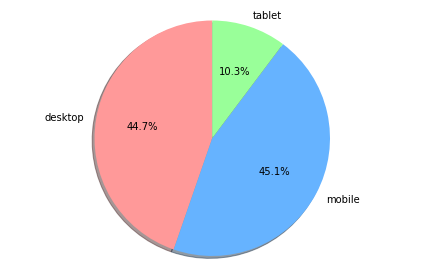

In [19]:
labels = ['desktop', 'mobile', 'tablet']
explode = (0, 0, 0)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
fig1, ax1 = plt.subplots()
ax1.pie(platform_dist, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.tight_layout()
plt.show()

In [20]:
traffic_source_dist = pv.groupby('traffic_source').size()

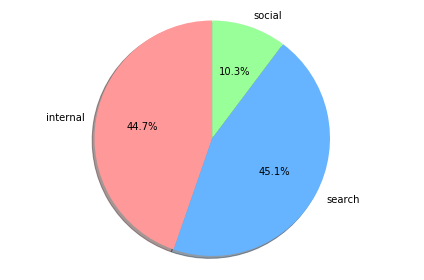

In [21]:
labels = ['internal', 'search', 'social']
explode = (0, 0, 0)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
fig1, ax1 = plt.subplots()
ax1.pie(platform_dist, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.tight_layout()
plt.show()

In [22]:
pv['datetime'] = pv['timestamp'].apply(lambda t: datetime.datetime.fromtimestamp((t + 1465876799998)/1000))
events['datetime'] = events['timestamp'].apply(lambda t: datetime.datetime.fromtimestamp((t + 1465876799998)/1000))

In [23]:
pv_events = pv.merge(events, on=['document_id', 'uuid'])

#### It's always a good idea to check the timeline

In [24]:
pv_events['date_hour_x'] = pv_events['datetime_x'].apply(lambda d: str(d.date()) + '-' + str(d.hour))

In [25]:
pv_events_datetime = pv_events.groupby(['datetime_x']).size()

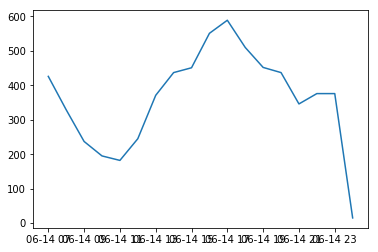

In [26]:
plt.plot(pv_events_datetime.resample('60T').sum())

In [27]:
pv_events_clicks = pv_events.merge(clicks_train, on=['display_id'])

#### Let's make sure that every tuple of (document_id, uuid, display_id, ad_id) is unique:

In [28]:
pv_events_clicks.groupby(['document_id', 'uuid', 'display_id', 'ad_id']).filter(lambda x: len(x) > 1)

,uuid,document_id,timestamp_x,platform_x,geo_location_x,traffic_source,datetime_x,display_id,timestamp_y,platform_y,geo_location_y,datetime_y,date_hour_x,ad_id,clicked


Indeed, we can see that there are no duplicates! Great :D

Let's see what is the conversion per traffic_source:

In [29]:
pv_events_clicks.groupby(['traffic_source']).apply(lambda x: len(x[x['clicked'] == 1]) / len(x))

traffic_source
1    0.180701
2    0.187158
3    0.193527
dtype: float64

#### CTR Distribution among ads

In [30]:
ad_ctr = clicks_train.groupby('ad_id').apply(lambda x: len(x[x['clicked'] == 1]) / len(x))

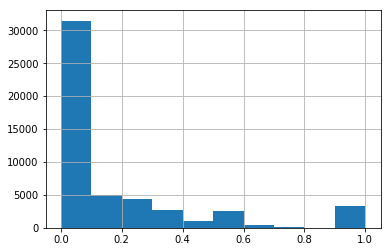

In [31]:
ad_ctr.hist()

In [36]:
clicks_train.groupby(['display_id', 'ad_id']).filter(lambda x: len(x) > 1)

,display_id,ad_id,clicked


In [33]:
pv_events_clicks.corr()

,document_id,timestamp_x,platform_x,traffic_source,display_id,timestamp_y,ad_id,clicked
document_id,1.000000,-0.016984,0.179122,-0.237164,-0.028846,-0.027564,-0.096794,0.000857
timestamp_x,-0.016984,1.000000,-0.009330,-0.001669,0.992605,0.997060,0.116173,0.008389
platform_x,0.179122,-0.009330,1.000000,0.011247,-0.012860,-0.012103,-0.014827,0.000779
traffic_source,-0.237164,-0.001669,0.011247,1.000000,0.000068,-0.002221,0.099064,0.012989
display_id,-0.028846,0.992605,-0.012860,0.000068,1.000000,0.995492,0.119576,0.009151
timestamp_y,-0.027564,0.997060,-0.012103,-0.002221,0.995492,1.000000,0.115833,0.008830
ad_id,-0.096794,0.116173,-0.014827,0.099064,0.119576,0.115833,1.000000,-0.001159
clicked,0.000857,0.008389,0.000779,0.012989,0.009151,0.008830,-0.001159,1.000000


#### Let's try to run SVM and see what happens out of the box

In [40]:
feature_cols = ['traffic_source', 'platform_x', 'platform_y', 'ad_id', 'document_id', 'display_id', 'timestamp_x', 'timestamp_y']

In [48]:
X = pv_events_clicks[feature_cols][:6000]
y = pv_events_clicks['clicked'][:6000]
clf = SVC()
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [60]:
y_pred = clf.predict(pv_events_clicks[feature_cols][6000:])

In [59]:
y_true = np.array(pv_events_clicks['clicked'][6000:])

In [61]:
accuracy_score(y_true, y_pred)

0.8270842523158359